In [1]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from src.fileutils import PROJECT_ROOT, MODELS_DIR
from src.camera.video import VideoStream
from src.pose.orientation_estimation import OrientationEstimation
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter
from ultralytics import YOLOWorld

In [3]:
model_path = PROJECT_ROOT / "models" / "doe" / "spindoe.ckpt"
use_gpu = False
orientation_estimator = OrientationEstimation(model_path, use_gpu, doe_expected_brightness=55)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\models\doe\spindoe.ckpt`


Saving hyperparmeters
DOE  initiated


In [4]:
rolling_video_path = PROJECT_ROOT / "data" / "orientation_images" / "rolling.mp4"
rolling_video = VideoStream(rolling_video_path)
print(rolling_video)

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\orientation_images\rolling.mp4
	FPS: 30.0
	Frames: 51
	Resolution: 1920x1080



In [5]:
# Init YOLO World
model = YOLOWorld(str(MODELS_DIR / 'yolov8l-world.pt'))
model.conf = 0.1
model.iou = 0.1

split_height = rolling_video.height // 3
split_width = rolling_video.width // 3
overlap = 0.3
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)
detector = SplitYoloDetector(model, splitter, ball_classes = ['ball', 'sports ball'])

In [6]:
model_path = MODELS_DIR / "doe" / "spindoe.ckpt"
use_gpu = False
orientation_estimator = OrientationEstimation(model_path, use_gpu, doe_expected_brightness=55)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\models\doe\spindoe.ckpt`


Saving hyperparmeters
DOE  initiated


Bounding box [960, 573, 1067, 681] detected with confidence 0.8798682689666748
(108, 107, 3)
Shape of preprocessed image (108, 1, 3)
(108, 1, 3)


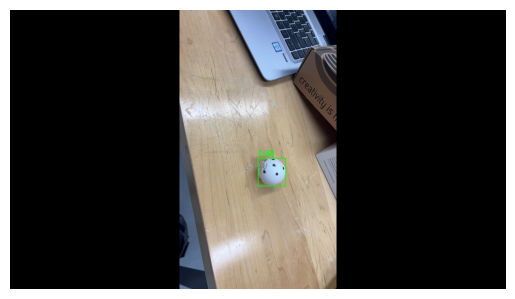

Bounding box [959, 571, 1067, 679] detected with confidence 0.8834673166275024
(108, 108, 3)
Shape of preprocessed image (108, 108, 3)
(108, 108, 3)


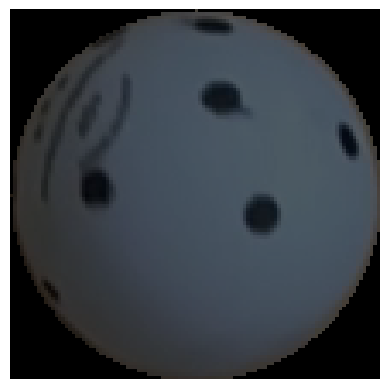

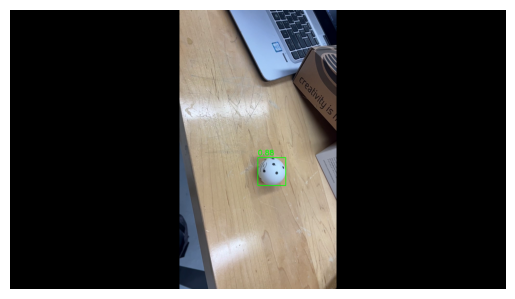

Bounding box [959, 569, 1066, 678] detected with confidence 0.8912333250045776
(109, 107, 3)
Shape of preprocessed image (108, 1, 3)
(108, 1, 3)


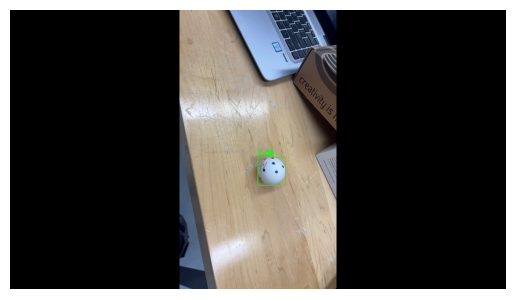

Bounding box [959, 568, 1066, 675] detected with confidence 0.8889996409416199
(107, 107, 3)
Shape of preprocessed image (106, 106, 3)
Estimated rotation: [    -54.206     -35.447      30.009] degrees
(60, 60, 3)


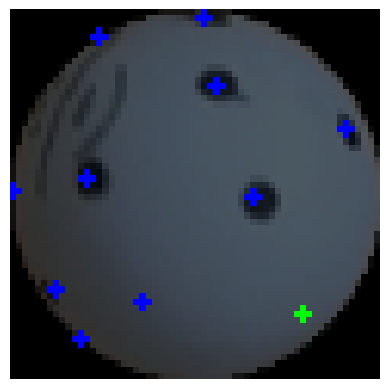

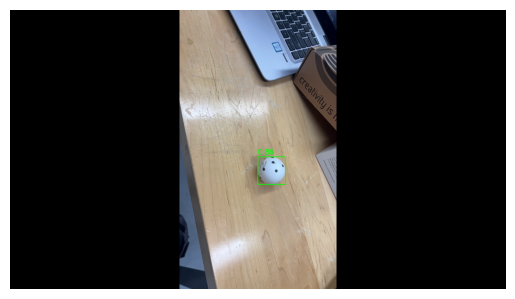

Bounding box [959, 566, 1065, 674] detected with confidence 0.8972352743148804
(108, 106, 3)
Shape of preprocessed image (108, 1, 3)
(108, 1, 3)


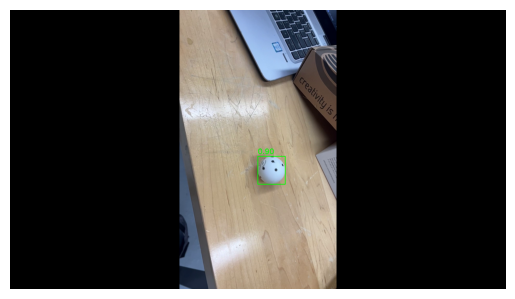

KeyboardInterrupt: 

In [7]:
annotated_frames = []
rots = []
aug_imgs = []

for frame in rolling_video:

    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = False)
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf}")
        detector.draw_bounding_box(annotated_frame, box, conf)

        # Crop the ball from the frame
        cropped_ball = frame[box[1]:box[3], box[0]:box[2]]
        print(cropped_ball.shape)

        # Estimate the orientation of the ball
        rot, preprocessed_img, aug_img, heatmap = orientation_estimator.estimate_orientation_with_doe_debug(
                image=cropped_ball,
                ball_mask=None,
                ball_center_x=cropped_ball.shape[1]//2,
                ball_center_y=cropped_ball.shape[0]//2,
                ball_radius=min(cropped_ball.shape[0]//2, cropped_ball.shape[1]//2),
            )
        
        if rot is not None:
            print(f"Estimated rotation: {rot.as_euler('xyz', degrees=True)} degrees")
        rots.append(rot)
        aug_imgs.append(aug_img)
        print(aug_img.shape)

        plt.figure()
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    else:
        print("No ball detected")

    # Display the image with detected circles
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    annotated_frames.append(annotated_frame)

In [ ]:
# Get the dimensions of the first image
height, width, _ = annotated_frames[0].shape

# Create a VideoWriter object to save the stitched video
output_path = 'stitched_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))

# Write each frame to the video
for frame in annotated_frames:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Stitched video saved at {output_path}")


IndexError: list index out of range